In [1]:
import os
import time
import random
import easydict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

seed = 42
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [2]:
def transform_label(label):
    if label == 1:
        return -1
    if label == 0:
        return 1
    
def make_dataloader(data_dir, args, shuffle):
    data_transform = transforms.Compose([transforms.Grayscale(), transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, data_transform, transform_label)
    dataloader = DataLoader(dataset, args.batch_size, shuffle, num_workers=0)
    return dataloader

def make_augmented_dataloader(data_dir, args, shuffle):
    data_transform = transforms.Compose([transforms.Grayscale(),
                                         transforms.RandomApply([transforms.RandomVerticalFlip(0.2),
                                                                 transforms.RandomHorizontalFlip(0.2),
                                                                 transforms.RandomInvert(0.5),
                                                                 transforms.RandomRotation(180),
                                                                 transforms.RandomAutocontrast()]),
                                         transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, data_transform, transform_label)
    dataloader = DataLoader(dataset, args.batch_size, shuffle, num_workers=args.num_workers_dataloader, drop_last=True)
    return dataloader

In [3]:
class Attention(nn.Module):
    def __init__(self, in_channels):
        super(Attention, self).__init__()
        self.make_q=nn.Conv2d(in_channels,in_channels,1)
        self.make_k = nn.Conv2d(in_channels, in_channels, 1)
        self.make_v = nn.Conv2d(in_channels, in_channels, 1)
        self.l=nn.Conv2d(in_channels, in_channels, 1)
        self.m=nn.Softmax(dim=2)
        self.n=in_channels


    def forward(self, x):
        q=self.make_q(x).view(x.size(0),x.size(1),-1).transpose(1,2)

        k = self.make_k(x).view(x.size(0),x.size(1),-1)

        v = self.make_v(x).view(x.size(0),x.size(1),-1).transpose(1,2)

        att=self.m(torch.matmul(q,k))#/np.sqrt(self.n))

        out=torch.matmul(att,v).transpose(1,2).view(x.size(0),x.size(1),x.size(2),x.size(3))
        out=self.l(out)

        return out+x

class Deep_SVDD(nn.Module):
    def __init__(self, args):
        super(Deep_SVDD, self).__init__()
        self.num_filter = args.num_filter
        self.latent_dim = args.latent_dim
        act_fn = nn.LeakyReLU(inplace=True)

        self.down_1 = conv_block_2(1, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter * 1, self.num_filter * 2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_22(self.num_filter * 8, self.num_filter * 16, act_fn)
        self.attention = Attention(self.num_filter * 16)
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(self.num_filter * 16 * 62* 25, self.latent_dim)


    def forward(self, x):
        down_1 = self.down_1(x)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)
        attention = self.attention(bridge)
        flatten = self.flatten(attention)
        bottleneck = self.linear_1(flatten)
        return bottleneck

class Unet_attention(nn.Module):
    def __init__(self, args):
        super(Unet_attention, self).__init__()
        self.num_filter = args.num_filter
        self.latent_dim = args.latent_dim
        act_fn = nn.LeakyReLU(inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(1, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter * 1, self.num_filter * 2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_22(self.num_filter * 8, self.num_filter * 16, act_fn)
        self.attention = Attention(self.num_filter * 16)
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(self.num_filter * 16 * 62* 25, self.latent_dim)
        self.linear_2 = nn.Linear(self.latent_dim, self.num_filter * 16 * 62* 25)

        self.trans_1 = conv_trans_block(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.up_1 = conv_block_22(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.up_2 = conv_block_22(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.up_3 = conv_block_22(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter * 2, self.num_filter * 1, act_fn)
        self.up_4 = conv_block_22(self.num_filter * 2, self.num_filter * 1, act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter, 1, 1),
            # 필수는 아님
        )


    def encoder(self, input):
        down_1 = self.down_1(input)                # (B, 1, 1000, 406) --> ()
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)
        attention = self.attention(bridge)
        flatten = self.flatten(attention)
        bottleneck = self.linear_1(flatten)
        return bottleneck

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)
        attention = self.attention(bridge)
        flatten = self.flatten(attention)
        bottleneck = self.linear_1(flatten)
        bottleneck = self.linear_2(bottleneck)
        bottleneck = bottleneck.view(attention.size(0), attention.size(1), attention.size(2), attention.size(3))

        trans_1 = self.trans_1(bottleneck)
        concat_1 = cutandcat(trans_1, down_4)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = cutandcat(trans_2, down_3)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = cutandcat(trans_3, down_2)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = cutandcat(trans_4, down_1)
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out
    
def cutandcat(de, en):
    diffY = en.size()[2] - de.size()[2] # 1
    diffX = en.size()[3] - de.size()[3] # 0

    de = F.pad(de, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2], 'reflect')

    cat = torch.cat([en, de], dim=1)

    return cat

def conv_block(in_dim, out_dim, act_fn):

    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )

    return model

def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        # conv_block(in_dim, out_dim, act_fn),
        # conv_block(out_dim, out_dim, act_fn)
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn
        )
    return model

# except batch norm when Up sampling
def conv_block_22(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        act_fn,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        act_fn
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool
def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2, padding=0),act_fn
    )
    return model


In [4]:
class TrainerDeepSVDD:
    def __init__(self, args, data_loader, dataloader_test, device):
        self.args = args
        self.train_loader = data_loader
        self.dataloader_test = dataloader_test
        self.device = device
        self.writer = SummaryWriter(log_dir=self.args.output_path)

    def plot_classes_preds(self, net):
        net.eval()
        with torch.no_grad():
            for x_cpu, _ in self.dataloader_test:
                fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(4, 10))
                x = x_cpu.float().to(self.device)
                x_hat = net(x).detach().cpu()
                axs[0][0].imshow(x_cpu[0, 0, :, :], cmap='gray')
                axs[0][0].set_title('input')
                axs[1][0].imshow(x_cpu[51, 0, :, :], cmap='gray')
                axs[1][0].set_title('input')
                axs[0][1].imshow(x_hat[0, 0, :, :], cmap='gray')
                axs[0][1].set_title('output')
                axs[1][1].imshow(x_hat[51, 0, :, :], cmap='gray')
                axs[1][1].set_title('output')
                net.train()
                break
        return fig

    def pretrain(self):
        ae = Unet_attention(self.args).to(self.device)
        ae.apply(weights_init_normal)
        optimizer = torch.optim.Adam(ae.parameters(),
                                     lr=self.args.lr_ae,
                                     weight_decay=self.args.weight_decay_ae
                                     )
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                         milestones=self.args.lr_milestones,
                                                         gamma=0.1
                                                         )
        # self.writer.add_graph(ae, torch.randn(1, 1, self.args.image_height, self.args.image_width).to(self.device))
        summary(ae, (1, 1, self.args.image_height, self.args.image_width), row_settings=["var_names"])
        ae.train()

        losses = []
        for epoch in range(self.args.num_epochs_ae):
            start = time.time()
            total_loss = 0
            for x, _ in self.train_loader:
                x = x.float().to(self.device)

                optimizer.zero_grad()
                x_hat = ae(x)
                reconst_loss = torch.mean(torch.sum((x_hat - x) ** 2, dim=tuple(range(1, x_hat.dim()))))
                reconst_loss.backward()
                optimizer.step()

                total_loss += reconst_loss.item()
            scheduler.step()
            loss_temp = total_loss/len(self.train_loader)
            self.writer.add_scalar('Loss/AutoEncoder', loss_temp, epoch+1)
            losses.append(loss_temp)
            self.writer.add_figure('actuals vs. predictions', self.plot_classes_preds(ae), global_step=epoch+1)
            if loss_temp <= min(losses):
                c = self.set_c(ae, self.train_loader)
                torch.save({'center': c.cpu().data.numpy().tolist(), 'net_dict': ae.state_dict()},
                           self.args.output_path+'AE_best_save.pth'
                           )
                ae.train()
                print(f'save best model at {epoch+1} epoch')
            print(f'Pretraining Autoencoder... Epoch: {epoch+1}, Loss: {loss_temp:.6f}, Time: {time.time()-start}')
        plot_image(self.args, losses, 'AE')

        self.save_weights_for_DeepSVDD(ae)

    def save_weights_for_DeepSVDD(self, model):
        state_dict = torch.load(self.args.output_path+'AE_best_save.pth')
        model.load_state_dict(state_dict['net_dict'])
        c = torch.Tensor(state_dict['center']).to(self.device)
        net = Deep_SVDD(self.args).to(self.device)
        state_dict = model.state_dict()
        net.load_state_dict(state_dict, strict=False)
        torch.save({'center': c.cpu().data.numpy().tolist(), 'net_dict': net.state_dict()},
                   self.args.output_path+'pretrained_SVDD.pth'
                   )

    def set_c(self, model, dataloader, eps=0.1):
        model.eval()
        z_ = []
        with torch.no_grad():
            for x, _ in dataloader:
                x = x.float().to(self.device)
                z = model.encoder(x)
                z_.append(z.detach())
        z_ = torch.cat(z_)
        c = torch.mean(z_, dim=0)
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps
        return c

    def train(self):
        net = Deep_SVDD(self.args).to(self.device)
        if self.args.pretrain is True:
            state_dict = torch.load(self.args.output_path+'pretrained_SVDD.pth')
            net.load_state_dict(state_dict['net_dict'])
            c = torch.Tensor(state_dict['center']).to(self.device)
        else:
            net.apply(weights_init_normal)
            c = torch.randn(self.args.latent_dim).to(self.device)

        optimizer = torch.optim.Adam(net.parameters(), lr=self.args.lr, weight_decay=self.args.weight_decay)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.args.lr_milestones, gamma=0.1)
        print(summary(net, (self.args.batch_size, 1, self.args.image_height, self.args.image_width)))
        losses = []
        net.train()
        for epoch in range(self.args.num_epochs):
            start = time.time()
            total_loss = 0
            for x, y in self.train_loader:
                x = x.float().to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()
                z = net(x)
                loss = torch.mean(torch.sum((z - c) ** 2, dim=1)**y)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            scheduler.step()
            loss_temp = total_loss/len(self.train_loader)
            self.writer.add_scalar('Loss/Deep_SVDD', loss_temp, epoch+1)
            losses.append(loss_temp)

            if loss_temp <= min(losses):
                net.eval()
                torch.save({'center': c.cpu().data.numpy().tolist(), 'net_dict': net.state_dict()},
                           self.args.output_path+'Deep_SVDD_best_save.pth'
                           )
                net.train()
                print(f'save best model at {epoch+1} epoch')
            print(f'Training Deep SVDD... Epoch: {epoch+1}, Loss: {loss_temp:.6f}, Time: {time.time()-start}')
        self.writer.flush()
        self.writer.close()
        plot_image(self.args, losses, 'Deep_SVDD')

def plot_image(args, losses, type):
    losses = np.array(losses)
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.plot(losses)
    plt.savefig(args.output_path + type + '_Loss.png', format='png')
    np.save(args.output_path + type + '_Loss.npy', losses)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1 and classname != 'Conv':
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("Linear") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)



------Initiating U-Net------



IndexError: index 51 is out of bounds for dimension 0 with size 32

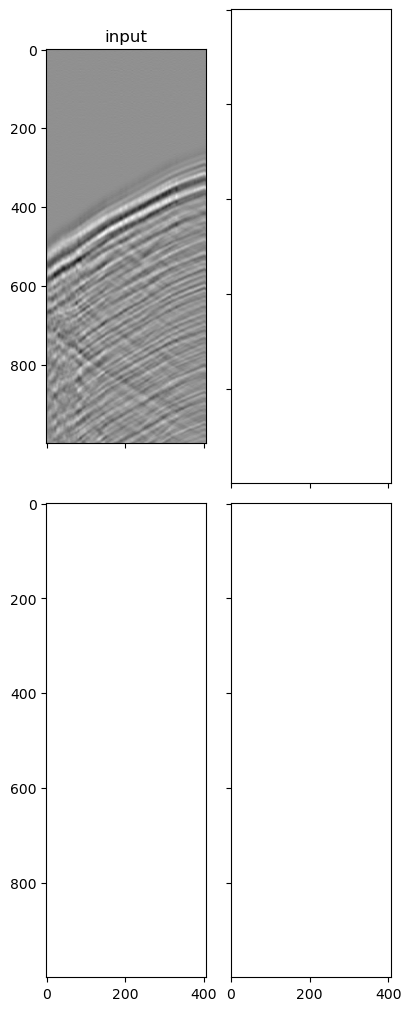

In [5]:
args = easydict.EasyDict({'num_epochs_ae': 100,
                          'lr_ae': 1e-3,
                          'num_epochs': 200,
                          'lr': 1e-5,
                          'weight_decay': 5e-6,
                          'weight_decay_ae': 5e-4,  # default = 5e-3
                          'lr_milestones': [100, 150],  # default = 50
                          'num_filter': 8,
                          'latent_dim': 128,
                          'batch_size': 32,
                          'pretrain': True,
                          'image_height': 1000,
                          'image_width': 406,
                          'num_workers_dataloader': 0,
                          'output_path': './output/4/'
                          })
os.mkdir(args.output_path)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloader_train = make_augmented_dataloader(data_dir='../image/das_image', args=args, shuffle=True)
dataloader_test = make_dataloader(data_dir='../image/1026_test', args=args, shuffle=False)

deep_SVDD = TrainerDeepSVDD(args, dataloader_train, dataloader_test, device)

    # DeepSVDD를 위한 DeepLearning pretrain 모델로 Weight 학습
if args.pretrain:
    deep_SVDD.pretrain()

deep_SVDD.train()

In [ ]:
def test_eval(net, c, device, test_dataset):
    """Testing the Deep SVDD model"""

    scores = []
    labels = []
    x_list = []
    z_list = []
    net.eval()
    print('Testing...')
    with torch.no_grad():
        for x, y in test_dataset:
            x = x.float().to(device)
            z = net(x)
            score = torch.mean((z - c) ** 2, dim=1)
          
            x_list.append(x.detach().cpu())
            z_list.append(((z-c)**2).detach().cpu())
            scores.append(score.detach().cpu())
            labels.append(y.cpu())

    x_list = torch.cat(x_list).numpy()
    z_list = torch.cat(z_list).numpy()
    labels, scores = torch.cat(labels).numpy(), torch.cat(scores).numpy()

    return labels, scores, z_list, x_list

def get_tsne(data, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=908)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

def plot_tsne(x_list, z_list, labels):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 5))
    x_list = x_list.reshape((x_list.shape[0],1000*406))

    tsne_data = get_tsne(x_list)
    scatter = axs[0].scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels)
    handles, labels_before = scatter.legend_elements()
    axs[0].legend(handles = handles, labels = labels_before)
    axs[0].set_title('before')

    tsne_data = get_tsne(z_list)
    scatter = axs[1].scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels)
    handles, labels_after = scatter.legend_elements()
    axs[1].legend(handles = handles, labels = labels_after)
    axs[1].set_title('after')


Testing...
ROC AUC score: 44.01


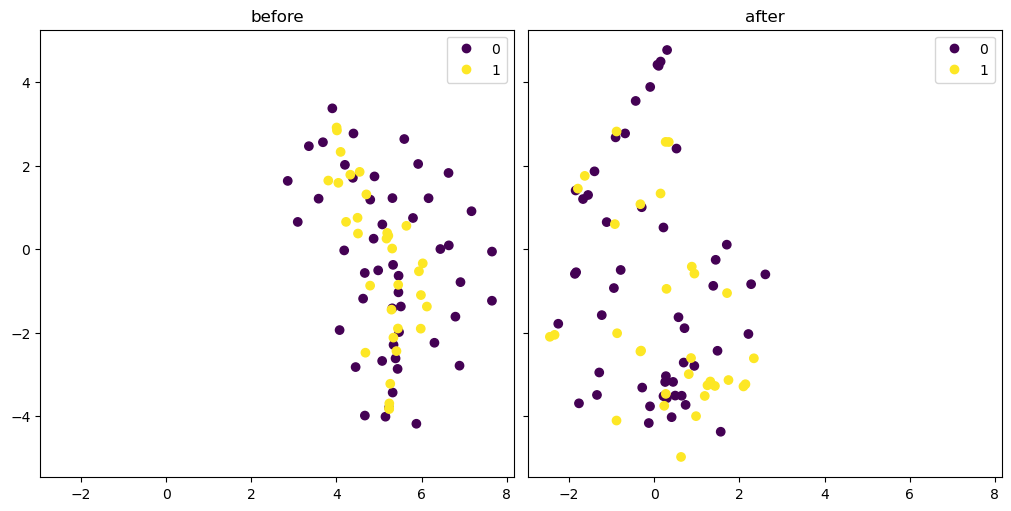

In [ ]:
net = Deep_SVDD(args).to(device)
net.eval()
state_dict = torch.load(args.output_path + 'Deep_SVDD_best_save.pth')
net.load_state_dict(state_dict['net_dict'])
c = torch.Tensor(state_dict['center']).to(device)
dataloader_test = make_dataloader(data_dir='../image/1026_test', args=args, shuffle=False)

labels, scores, z_list, x_list = test_eval(net, c, device, dataloader_test)
labels[labels==1] = 0  # Normals
labels[labels==-1] = 1  # Anomalies

print('ROC AUC score: {:.2f}'.format(roc_auc_score(labels, scores)*100))

plot_tsne(x_list, z_list, labels)


##### Unused code

In [8]:
state_dict = torch.load('output/attention_07________/AE_best_save.pth')
ae = Unet_attention(args).to(device)
# print(state_dict['net_dict'])
ae.load_state_dict(state_dict['net_dict'])
c = torch.Tensor(state_dict['center']).to(device)

# net = Deep_SVDD(args).to(device)
# state_dict = ae.state_dict()
# net.load_state_dict(state_dict, strict=False)

# torch.save({'center': c.cpu().data.numpy().tolist(), 'net_dict': net.state_dict()},
#             self.args.output_path+'pretrained_SVDD.pth'
#             )

FileNotFoundError: [Errno 2] No such file or directory: 'output/attention_07________/AE_best_save.pth'

In [ ]:
a = 0
b = 4
ae.eval()
with torch.no_grad():
    for x_cpu, _ in dataloader_train:
        fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(4, 10))
        # x_cpu = x_cpu.reshape((args.batch_size, args.image_height, args.image_width))
        x = x_cpu.float().to(device)
        x_hat = ae(x).detach().cpu()
        axs[0][0].imshow(x_cpu[a, 0, :, :], cmap='gray')
        axs[0][0].set_title('input')
        axs[1][0].imshow(x_cpu[b, 0, :, :], cmap='gray')
        axs[1][0].set_title('input')
        axs[0][1].imshow(x_hat[a, 0, :, :], cmap='gray')
        axs[0][1].set_title('output')
        axs[1][1].imshow(x_hat[b, 0, :, :], cmap='gray')
        axs[1][1].set_title('output')
        ae.train()
        break

In [ ]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=4, dilation=1):
        super(CBAM, self).__init__()

        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.global_maxpool = nn.AdaptiveMaxPool2d(1)

        channels = in_channels // reduction
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, channels, bias=True),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(channels, 1 * in_channels, bias=True),
        )

        self.relu = nn.LeakyReLU(0.1, inplace=True)
        self.sigmoid = nn.Sigmoid()

        self.conv = nn.Sequential(
            nn.Conv2d(2, 1, 7, stride=1, padding=(3 * dilation), dilation=dilation, bias=False),
        )

    def forward(self, x):
        a = self.global_avgpool(x).view(x.size(0), -1)
        m = self.global_maxpool(x).view(x.size(0), -1)
        a1=self.mlp(a)
        m1=self.mlp(m)
        cmap=self.sigmoid(a1+m1)


        #cmap = self.sigmoid(self.mlp(torch.cat((a, m), dim=1)))
        cmap = cmap.view(cmap.size(0), cmap.size(1), 1, 1)
        c = cmap * x

        a = torch.mean(c, 1).unsqueeze(1)
        m = torch.max(c, 1)[0].unsqueeze(1)

        smap = self.sigmoid(self.conv(torch.cat((a, m), dim=1)))
        s = smap * c
        return s


class Unet_CBAM(nn.Module):
    def __init__(self, in_dim, out_dim, num_filter):
        super(Unet_CBAM, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        self.c = CBAM(num_filter)
        act_fn = nn.LeakyReLU(inplace=True)

        print("\n------Initiating U-Net------\n")

        self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter * 1, self.num_filter * 2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter * 2, self.num_filter * 4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter * 4, self.num_filter * 8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_22(self.num_filter * 8, self.num_filter * 16, act_fn)
        # self.attention = Attention(self.num_filter * 16)
        self.trans_1 = conv_trans_block(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.cbam_1 = CBAM(num_filter * 8)
        self.up_1 = conv_block_22(self.num_filter * 16, self.num_filter * 8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.cbam_2 = CBAM(num_filter * 4)
        self.up_2 = conv_block_22(self.num_filter * 8, self.num_filter * 4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.cbam_3 = CBAM(num_filter * 2)
        self.up_3 = conv_block_22(self.num_filter * 4, self.num_filter * 2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter * 2, self.num_filter * 1, act_fn)
        self.cbam_4 = CBAM(num_filter)
        self.up_4 = conv_block_22(self.num_filter * 2, self.num_filter * 1, act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter, self.out_dim, 1),
            # 필수는 아님
        )
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(self.num_filter * 16 * 62* 25, 128)
        self.linear_2 = nn.Linear(128, self.num_filter * 16 * 62* 25)

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)
        # attention = self.attention(bridge)

        flatten = self.flatten(bridge)
        bottleneck = self.linear_1(flatten)
        bottleneck = self.linear_2(bottleneck)
        bottleneck = bottleneck.view(bridge.size(0), bridge.size(1), bridge.size(2), bridge.size(3))


        trans_1 = self.trans_1(bridge)
        concat_1 = cutandcat(trans_1,  self.cbam_1(down_4))
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = cutandcat(trans_2, self.cbam_2(down_3))
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = cutandcat(trans_3, self.cbam_3(down_2))
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = cutandcat(trans_4, self.cbam_4(down_1))
        up_4 = self.up_4(concat_4)
        out = self.out(up_4)
        return out

def cutandcat(x1, x2):
    diffY = x2.size()[2] - x1.size()[2]
    diffX = x2.size()[3] - x1.size()[3]

    x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2], 'reflect')

    x = torch.cat([x2, x1], dim=1)

    return x

def conv_block(in_dim, out_dim, act_fn):

    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )

    return model

def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn)
    )
    return model

# except batch norm when Up sampling
def conv_block_22(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        act_fn,
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        act_fn
    )
    return model

def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool
def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2, padding=0),act_fn
    )
    return model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ae = Unet_CBAM(1, 1, 4).to(device)
summary(ae, (64, 1, 1000, 406), row_settings=["var_names"])

In [ ]:
a = 0
b = 3
ae.eval()
with torch.no_grad():
    for x_cpu, _ in dataloader_train:
        fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(4, 10))
        # x_cpu = x_cpu.reshape((args.batch_size, args.image_height, args.image_width))
        x = x_cpu.float().to(device)
        x_hat = ae(x).detach().cpu()
        axs[0][0].imshow(x_cpu[a, 0, :, :], cmap='gray')
        axs[0][0].set_title('input')
        axs[1][0].imshow(x_cpu[b, 0, :, :], cmap='gray')
        axs[1][0].set_title('input')
        axs[0][1].imshow(x_hat[a, 0, :, :], cmap='gray')
        axs[0][1].set_title('output')
        axs[1][1].imshow(x_hat[b, 0, :, :], cmap='gray')
        axs[1][1].set_title('output')
        ae.train()
        break

In [ ]:
"""class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio, channel_attention=True, spatial_attention=True):
        super(CBAM, self).__init__()
        self.channel_attention, self.spatial_attention = channel_attention, spatial_attention
        if channel_attention:
            self.ChannelGate = ChannelGate(gate_channels, reduction_ratio)
        if spatial_attention:
            self.SpatialGate = SpatialGate()
    
    def forward(self, x):
        if self.channel_attention:
            x = self.ChannelGate(x)
        if self.spatial_attention:
            x = self.SpatialGate(x)
        return x


class ChannelGate(nn.Module):
	def __init__(self, gate_channels, reduction_ratio=16):
		super(ChannelGate, self).__init__()
		self.gate_channels = gate_channels
		self.mlp = nn.Sequential(
			nn.Flatten(),
			nn.Linear(gate_channels, gate_channels // reduction_ratio),
			nn.ReLU(),
			nn.Linear(gate_channels // reduction_ratio, gate_channels),
			nn.Sigmoid()
			)
		self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
		self.maxpool = nn.AdaptiveMaxPool2d((1, 1))

	def forward(self, x):
		x_avg_pool = self.mlp(self.avgpool(x))
		x_max_pool = self.mlp(self.maxpool(x))
		attention = x_avg_pool + x_max_pool
		attention = attention.unsqueeze(2).unsqueeze(3).expand_as(x)
		return x*attention


class SpatialGate(nn.Module):
	def __init__(self):
		super(SpatialGate, self).__init__()
		self.conv = nn.Sequential(
			nn.Conv2d(2, 1, 7, padding=3),
			nn.BatchNorm2d(1),
			nn.Sigmoid()
			)
            
	def forward(self, x):
		x_avg_pool = torch.mean(x,1).unsqueeze(1)
		x_max_pool = torch.max(x,1)[0].unsqueeze(1)
		attention = torch.cat((x_avg_pool, x_max_pool), dim=1)
		attention = self.conv(attention)
		return x*attention"""